In [1]:
import numpy as np
import torch
from torch.utils.dlpack import to_dlpack, from_dlpack
import cupy as cu
from cupyx import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
W = 100
H = 100
N = W * H
arr = torch.rand(H, W, device=device, dtype=torch.float32) * 10
arr[25:50, 25:50] = 10# + torch.rand(25, 25) * 10
arr[30:45, 30:45] = 30
arr[35:40, 35:40] = 50
arr[37:39, 37:39] = 60
arr

tensor([[7.9818, 8.6376, 6.0729,  ..., 3.6112, 1.3229, 5.5282],
        [3.2518, 9.0914, 0.7611,  ..., 7.3713, 5.9811, 9.7562],
        [4.6507, 9.0056, 3.0840,  ..., 0.3312, 6.3089, 8.6558],
        ...,
        [4.5592, 6.2296, 3.8150,  ..., 8.8079, 2.0510, 8.5967],
        [3.3138, 2.8811, 7.0535,  ..., 2.3189, 9.1457, 3.4694],
        [8.3175, 3.6190, 0.7650,  ..., 4.6302, 0.1383, 5.5489]],
       device='cuda:0')

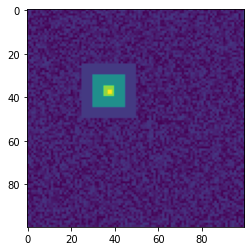

In [5]:
plt.imshow(arr.cpu().numpy())

In [6]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float32)

In [7]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:0'),
 torch.Size([4, 3, 3]))

In [8]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 4.7300, -0.4538,  5.3118,  ..., -3.7601, -4.6582, -4.2280],
          [-1.3988,  0.0859, -2.3229,  ...,  7.0401, -0.3278,  1.1004],
          ...,
          [ 2.4400,  3.1402, -2.0014,  ..., -0.0595,  3.4707, -1.9289],
          [ 1.2454,  3.3485, -3.2385,  ...,  6.4890, -7.0947,  5.1273],
          [-5.0037, -0.7379,  6.2885,  ..., -2.3113,  9.0074, -2.0794]],
 
         [[ 0.6558, -2.5648, -3.0987,  ..., -2.2883,  4.2053,  0.0000],
          [ 5.8396, -8.3304, -0.1341,  ..., -1.3902,  3.7751,  0.0000],
          [ 4.3549, -5.9216,  5.1108,  ...,  5.9777,  2.3469,  0.0000],
          ...,
          [ 1.6704, -2.4146, -3.2234,  ..., -6.7569,  6.5458,  0.0000],
          [-0.4327,  4.1724,  1.5959,  ...,  6.8268, -5.6763,  0.0000],
          [-4.6985, -2.8540,  7.1890,  ..., -4.4919,  5.4106,  0.0000]],
 
         [[-4.7300,  0.4538, -5.3118,  ...,  3.7601,  4.6582,  4.2280],
          [ 1.3988, -0.0859,

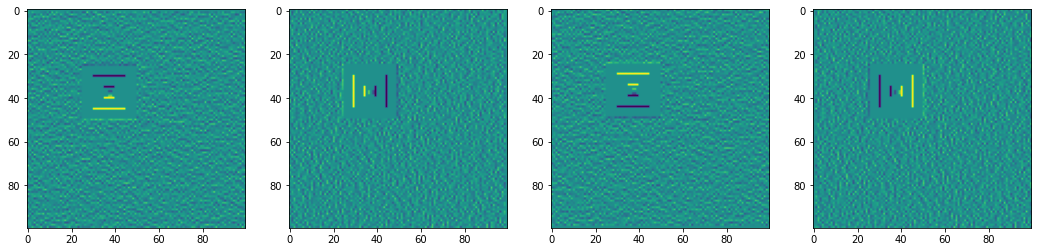

In [9]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [10]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [11]:
square, square.shape

(tensor([[[0.5979, 1.3764, 1.6280,  ..., 1.2486, 2.1613, 0.5000],
          [3.7906, 4.2012, 2.7034,  ..., 2.0659, 3.0393, 2.1723],
          [2.3410, 3.0030, 2.8512,  ..., 4.6448, 1.2860, 0.7434],
          ...,
          [1.5608, 2.0428, 1.9619,  ..., 3.4154, 3.7381, 1.0863],
          [0.8274, 2.7213, 1.8731,  ..., 4.7358, 4.5704, 2.6120],
          [3.4682, 1.5564, 4.8017,  ..., 2.5748, 5.2775, 1.1537]],
 
         [[2.4394, 1.3950, 3.1152,  ..., 2.2569, 3.1774, 2.1723],
          [3.0437, 4.1953, 1.2663,  ..., 3.6227, 1.9595, 0.7434],
          [3.0778, 3.3158, 3.5389,  ..., 3.0535, 1.3430, 0.5756],
          ...,
          [1.1556, 2.1239, 2.3387,  ..., 4.7107, 4.8524, 2.6120],
          [2.5605, 2.1768, 3.2822,  ..., 3.6382, 5.3468, 1.1537],
          [2.4019, 1.5121, 3.6291,  ..., 2.3009, 2.7511, 0.5000]],
 
         [[2.4173, 0.6395, 2.9914,  ..., 2.1284, 2.6427, 3.0233],
          [0.8598, 2.9626, 4.3529,  ..., 4.0702, 0.8718, 2.0287],
          [2.1753, 2.6400, 3.8418,  ...,

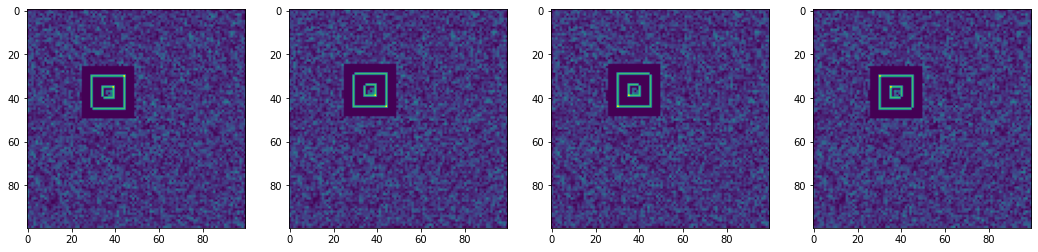

In [12]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [13]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [14]:
vertex_area = square.sum(axis=0)

In [15]:
vertex_area, vertex_area.shape

(tensor([[ 4.8567,  2.6324,  7.4830,  ...,  5.3830,  7.0688,  5.1845],
         [ 7.6941, 14.3301, 13.2877,  ..., 12.5355,  8.3522,  7.0788],
         [ 7.5941, 11.1934, 13.4514,  ..., 18.4118,  8.7232,  3.4396],
         ...,
         [ 3.5149,  7.9507,  8.0272,  ..., 17.9467, 17.3455,  8.7222],
         [ 5.9392,  7.3167, 11.6495,  ..., 16.6944, 20.5387,  9.5327],
         [ 5.8700,  5.4985, 11.9198,  ...,  6.2800, 13.0861,  4.0947]],
        device='cuda:0'),
 torch.Size([100, 100]))

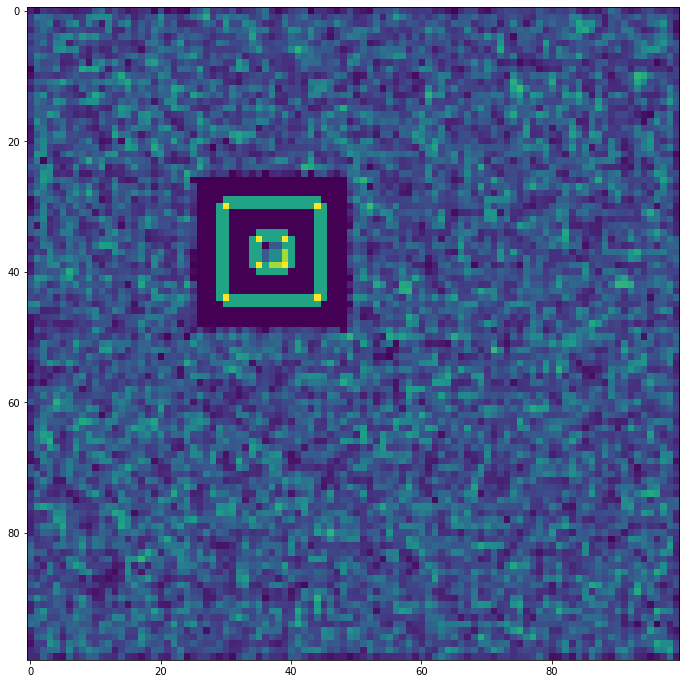

In [16]:
plt.imshow(vertex_area.cpu().numpy())

In [17]:
del arr
torch.cuda.empty_cache()

In [18]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[0, 0, :] = 0
cotangens[1, :, -1] = 0
cotangens[2, -1, :] = 0
cotangens[3, :, 0] = 0

In [19]:
main_i = torch.arange(end=N, device=device)
upper_edge_i = torch.arange(start=W, end=N, device=device)
right_edge_i = main_i[cotangens[1].view(-1) != 0]
left_edge_i = main_i[cotangens[3].view(-1) != 0]
down_edge_i = torch.arange(start=0, end=N-W, device=device)

In [20]:
main_v = cotangens.sum(axis=0).view(-1)
upper_edge_v = cotangens[0].view(-1)[upper_edge_i]
right_edge_v = cotangens[1].view(-1)[right_edge_i]
down_edge_v = cotangens[2].view(-1)[down_edge_i]
left_edge_v = cotangens[3].view(-1)[left_edge_i]

In [21]:
# cu.cuda.Device(0).use()

main_v = cu.fromDlpack(to_dlpack(main_v + torch.rand_like(main_v)))
main_i = cu.fromDlpack(to_dlpack(main_i))

upper_edge_v = cu.fromDlpack(to_dlpack(upper_edge_v))
upper_edge_i = cu.fromDlpack(to_dlpack(upper_edge_i))

right_edge_v = cu.fromDlpack(to_dlpack(right_edge_v))
right_edge_i = cu.fromDlpack(to_dlpack(right_edge_i))

down_edge_v = cu.fromDlpack(to_dlpack(down_edge_v))
down_edge_i = cu.fromDlpack(to_dlpack(down_edge_i))


left_edge_v = cu.fromDlpack(to_dlpack(left_edge_v))
left_edge_i = cu.fromDlpack(to_dlpack(left_edge_i))

In [22]:
upper_m = scipy.sparse.coo_matrix((upper_edge_v / 2, (upper_edge_i, main_i[:-W])), shape=(N, N))
right_m = scipy.sparse.coo_matrix((right_edge_v / 2, (right_edge_i, right_edge_i + 1)), shape=(N, N))
down_m = scipy.sparse.coo_matrix((down_edge_v / 2, (down_edge_i, main_i[W:])), shape=(N, N))
left_m = scipy.sparse.coo_matrix((left_edge_v / 2, (left_edge_i, left_edge_i - 1)), shape=(N, N))
main_m = scipy.sparse.diags(-main_v / 2)

In [23]:
L = main_m + upper_m + right_m + down_m + left_m

In [24]:
M = scipy.sparse.diags(cu.fromDlpack(to_dlpack(vertex_area.view(-1) / 3)))

In [25]:
M.dtype, L.dtype

(dtype('float32'), dtype('float32'))

In [26]:
b = cu.zeros(N, dtype=cu.float32)
b[50 * W + 50] = 1
# b[3*W+20] = 1
b.dtype

dtype('float32')

In [27]:
del main_m, upper_m, right_m, down_m, left_m
del vertex_area
del main_v, main_i, upper_edge_v, upper_edge_i, right_edge_v, right_edge_i, down_edge_v, down_edge_i, left_edge_v, left_edge_i
torch.cuda.empty_cache()

2.12336802482605

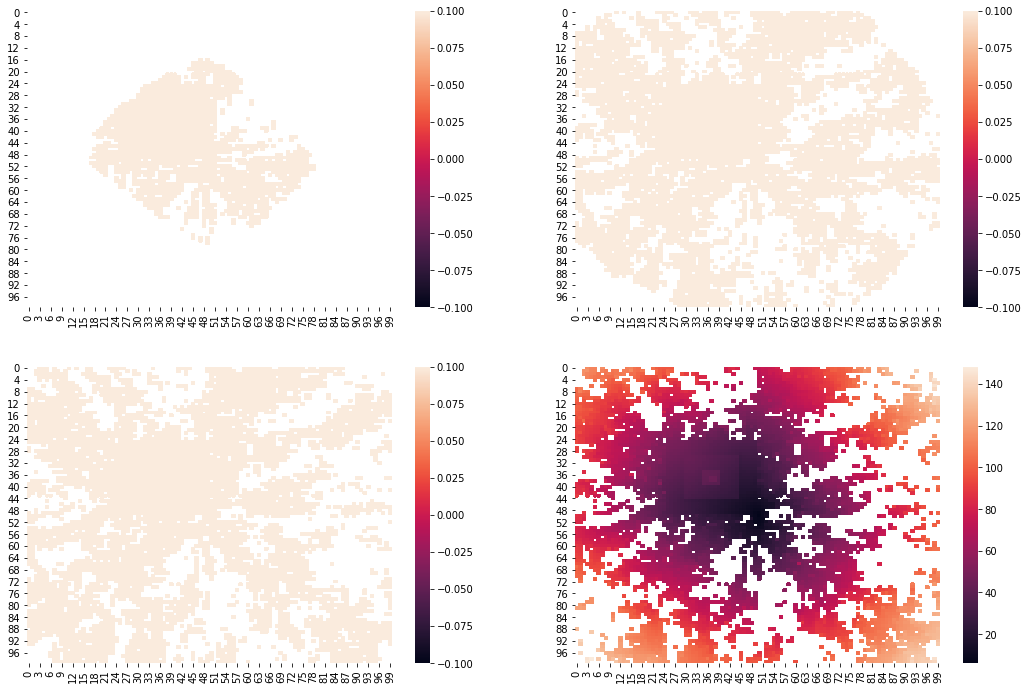

In [28]:
# u = scipy.sparse.linalg.lsqr(M - L, b)
# u = u[0]
start = time.time()
for i in range(4):
    t = (0.1 + i)
    u = scipy.sparse.linalg.lsqr(M - t * L, b)
    u = u[0]
    plt.subplot(2, 2, 1 + i)
    sns.heatmap(cu.asnumpy((-t ** 0.5 * cu.log(u)).reshape(H, W)))

end = time.time()
end - start
#     del u
#     torch.cuda.empty_cache()

In [29]:
(u == 0).sum(), u.shape[0]

(array(0), 10000)

In [30]:
# _ = plt.hist(cu.asnumpy(u.reshape(H, W).clip(0, 0.1)))

In [31]:
vectors = cu.fromDlpack(to_dlpack(vectors))
e1 = cu.zeros(shape=(3, H, W), dtype=cu.float32)
e2 = cu.zeros(shape=(3, H, W,), dtype=cu.float32)

e1[0, :, :] = -1
e1[2, :, :] = vectors[0]
e2[1:, :,] = 1
e2[2:, :,] = vectors[1]
cross_n1 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = 1
e1[2, :, :] = vectors[1]
e2[0:, :,] = 1
e2[2:, :,] = vectors[2]
cross_n2 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[0, :, :] = 1
e1[2, :, :] = vectors[2]
e2[1:, :,] = -1
e2[2:, :,] = vectors[3]
cross_n3 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = -1
e1[2, :, :] = vectors[3]
e2[0:, :,] = -1
e2[2:, :,] = vectors[0]
cross_n4 = cu.cross(e1, e2, axis=0)

In [32]:
cross_n = [cross_n1, cross_n2, cross_n3, cross_n4]

In [33]:
u = from_dlpack(u.toDlpack())
u = u.reshape(H, W)
vectors = from_dlpack(vectors.toDlpack())

In [34]:
def compute_gradient(kernel, u, cross_n, e1, e2, e3):
    u_ = torch.nn.functional.conv2d(input=u, weight=kernel, padding=1)[0]
    return u_[0] * torch.cross(cross_n, e1, dim=0) + u_[1] * torch.cross(cross_n, e2, dim=0) + u_[2] * torch.cross(cross_n, e3, dim=0)

In [35]:
gradients = []
kernels = [torch.tensor([[[0., 1., 0.], [0, 0, 0], [0, 0, 0]], 
                         [[0, 0, 0], [0., 0., 1.], [0, 0, 0]], 
                         [[0., 0., 0.], [0, 1, 0], [0, 0, 0]]], device=device, dtype=torch.float64),
           torch.tensor([[[0., 0., 0.], [0, 0, 1], [0, 0, 0]], 
                         [[0., 0., 0.], [0, 0, 0], [0, 1, 0]], 
                         [[0, 0, 0], [0., 1., 0.], [0, 0, 0]]], device=device, dtype=torch.float64),
           torch.tensor([[[0., 0., 0.], [0, 0, 0], [0, 1, 0]], 
                         [[0, 0, 0], [1., 0., 0.], [0, 0, 0]], 
                         [[0, 0, 0], [0., 1., 0.], [0, 0, 0]]], device=device, dtype=torch.float64),
           torch.tensor([[[0, 0, 0], [1, 0, 0], [0., 0., 0.]], 
                         [[0, 1, 0], [0., 0., 0.], [0, 0, 0]], 
                         [[0., 0., 0.], [0, 1, 0], [0, 0, 0]]], device=device, dtype=torch.float64),
          ]

e1 = from_dlpack(e1.toDlpack())
e2 = from_dlpack(e2.toDlpack())
e3 = torch.zeros_like(e2)

index = {0:((-1, 0), (0, 1)) , 1: ((0, 1), (1, 0)), 2: ((1, 0), (0, -1)), 3: ((0, -1), (-1, 0))}

for i, cross_e in enumerate(cross_n):
    f_, s_ = index[i]
    e1[0, ...] = f_[0]
    e1[1, ...] = f_[1]
    e2[0, ...] = s_[0]
    e2[1, ...] = s_[1]
    
    e1[2] = vectors[i % 4]
    e2[2] = vectors[(i + 1) % 4]
    gradients.append(compute_gradient(kernels[i][:, None], u[None, None], from_dlpack(cross_e.toDlpack()), e2, -e1, e1 - e2))

In [36]:
gradients[0].shape

torch.Size([3, 100, 100])

In [37]:
for i, g in enumerate(gradients):
    non_zero = square[i] != 0
    g[0][non_zero] /= 2 * square[i][non_zero]
    g[1][non_zero] /= 2 * square[i][non_zero]
    g[2][non_zero] /= 2 * square[i][non_zero]
    
gradients = [ -e / torch.norm(e, dim=0)[None] for e in gradients]

for i, g in enumerate(gradients):
    g[0][square[i] == 0] = 0
    g[1][square[i] == 0] = 0
    g[2][square[i] == 0] = 0

In [38]:
gradients[2]

tensor([[[ 0.0208, -0.8742, -0.2958,  ...,  0.3118,  0.4184, -0.3364],
         [-0.3117, -0.9754,  0.8986,  ...,  0.4996,  0.6426,  0.6571],
         [-0.1455, -0.8419, -0.7351,  ...,  0.0240,  0.6777,  0.1418],
         ...,
         [ 0.2465,  0.0313,  0.0795,  ...,  0.7893,  0.3211,  0.7781],
         [ 0.0308,  0.7703, -0.1716,  ..., -0.7223,  0.6051, -0.8708],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.9949, -0.1145,  0.8100,  ...,  0.8827,  0.9012,  0.5242],
         [-0.8442, -0.0511,  0.2901,  ...,  0.8585,  0.5415,  0.3661],
         [-0.7743, -0.5393, -0.5220,  ...,  0.1067, -0.2130,  0.3587],
         ...,
         [-0.9193, -0.4664, -0.2886,  ...,  0.6028,  0.2002,  0.6224],
         [-0.9876,  0.5436, -0.4666,  ..., -0.3363,  0.7960, -0.3750],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0984, -0.4718, -0.5064,  ..., -0.3517, -0.1131,  0.7823],
         [-0.4361, -0.2145, -0.3293,  ..., -0

In [39]:
u[...] = 0
for i, g in enumerate(gradients):
    f_, s_ = index[i]
    e1[0, ...] = f_[0]
    e1[1, ...] = f_[1]
    e2[0, ...] = s_[0]
    e2[1, ...] = s_[1]
    e3 = e2 - e1
    theta1 = torch.acos(torch.sum(-e1 * e3, dim=0) / (torch.norm(e1, dim=0) * torch.norm(e3, dim=0)))
    theta2 = torch.acos(torch.sum(e2 * e3, dim=0) / (torch.norm(e2, dim=0) * torch.norm(e3, dim=0)))
    
    cot1 = 1 / torch.tan(theta1)
    cot1[cot1.isnan()] = 0
    cot2 = 1 / torch.tan(theta2)
    cot2[cot2.isnan()] = 0
    
    u += (cot1 * torch.sum(e1 * g, dim=0)  + cot2 * torch.sum(e2 * g, dim=0)) / 2

In [40]:
u = cu.fromDlpack(to_dlpack(u))

In [42]:
u_ = scipy.sparse.linalg.lsqr(L, u.flatten())

In [43]:
u_[0]

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
# L.toarray()